# **Cleaning of the Data**

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from dateutil.parser import parse
import datetime as dt
from scipy.stats import skew, kurtosis
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [122]:
# Loading the dataset
df  = pd.read_csv('/content/Foodpanda Analysis Dataset.csv')

In [123]:
# Quick Overview
print("Initial Shape:", df.shape)
print("\nInitial Columns:", df.columns.tolist())
print("\nData Types:\n", df.dtypes)
print("\nSample Data:\n", df.head())

Initial Shape: (6000, 20)

Initial Columns: ['customer_id', 'gender', 'age', 'city', 'signup_date', 'order_id', 'order_date', 'restaurant_name', 'dish_name', 'category', 'quantity', 'price', 'payment_method', 'order_frequency', 'last_order_date', 'loyalty_points', 'churned', 'rating', 'rating_date', 'delivery_status']

Data Types:
 customer_id         object
gender              object
age                 object
city                object
signup_date         object
order_id            object
order_date          object
restaurant_name     object
dish_name           object
category            object
quantity             int64
price              float64
payment_method      object
order_frequency      int64
last_order_date     object
loyalty_points       int64
churned             object
rating             float64
rating_date         object
delivery_status     object
dtype: object

Sample Data:
   customer_id  gender     age      city signup_date order_id order_date  \
0       C5663    Male 

In [124]:
# Dropping the unnecessary columns
unnecessary_cols = ['dish_name','order_id','rating_date']
df = df.drop(columns=unnecessary_cols, errors= 'ignore')
print("\nColumns After Drop:", df.columns.tolist())
print("New Shape:", df.shape)


Columns After Drop: ['customer_id', 'gender', 'age', 'city', 'signup_date', 'order_date', 'restaurant_name', 'category', 'quantity', 'price', 'payment_method', 'order_frequency', 'last_order_date', 'loyalty_points', 'churned', 'rating', 'delivery_status']
New Shape: (6000, 17)


In [125]:
# Function to parse mixed formats (numbers as Excel serial dates, strings as dates)
def parse_date(value):
    if isinstance(value, (int, float)):
        try:
            return dt.date(1899, 12, 30) + dt.timedelta(days=int(value))
        except:
            return pd.NaT
    else:
        try:
            return pd.to_datetime(str(value), errors='coerce')
        except:
            return pd.NaT

# Apply parsing to date columns
date_cols = ['signup_date', 'order_date', 'last_order_date']
for col in date_cols:
    df[col] = df[col].apply(parse_date)

# Sort dates per row: earliest to signup, middle to order, latest to last
def sort_dates(row):
    dates = [row['signup_date'], row['order_date'], row['last_order_date']]
    dates = [d for d in dates if pd.notna(d)]  # Remove NaT
    if len(dates) < 3:
        return row  # Skip if insufficient dates
    sorted_dates = sorted(dates)
    row['signup_date'] = sorted_dates[0]
    row['order_date'] = sorted_dates[1]
    row['last_order_date'] = sorted_dates[2]
    return row

df = df.apply(sort_dates, axis=1)

# Verify: No inconsistencies
print("\nOrder Before Signup:", (df['order_date'] < df['signup_date']).sum())
print("Order After Last:", (df['order_date'] > df['last_order_date']).sum())
print("\nMean Dates After Sorting:\n", df[date_cols].mean())
print("\nSample Rows After Sorting:\n", df[date_cols].head(10))


Order Before Signup: 0
Order After Last: 0

Mean Dates After Sorting:
 signup_date       2024-04-12 03:48:14.400
order_date        2024-11-04 18:55:55.200
last_order_date   2025-04-14 03:56:24.000
dtype: datetime64[ns]

Sample Rows After Sorting:
   signup_date order_date last_order_date
0  2023-08-23 2024-01-14      2025-07-19
1  2023-08-23 2024-07-07      2024-11-25
2  2023-08-23 2025-05-10      2025-06-20
3  2023-08-23 2023-09-05      2025-07-24
4  2023-08-24 2023-12-29      2024-12-21
5  2023-08-24 2023-09-28      2024-10-10
6  2023-08-24 2025-04-08      2025-05-25
7  2023-08-24 2024-02-05      2025-05-01
8  2023-08-24 2024-12-17      2025-05-16
9  2023-08-24 2023-10-13      2025-02-23


In [126]:
# Verifying the data type
print("\nData Types for all Columns:\n", df.dtypes)


Data Types for all Columns:
 customer_id                object
gender                     object
age                        object
city                       object
signup_date        datetime64[ns]
order_date         datetime64[ns]
restaurant_name            object
category                   object
quantity                    int64
price                     float64
payment_method             object
order_frequency             int64
last_order_date    datetime64[ns]
loyalty_points              int64
churned                    object
rating                    float64
delivery_status            object
dtype: object


In [127]:
# Removing the white space
df.columns = df.columns.str.strip()

In [128]:
# Trim spaces in string columns (e.g., gender, city, etc.)
string_cols = df.select_dtypes(include='object').columns
df[string_cols] = df[string_cols].apply(lambda x: x.str.strip() if x.dtype == 'object' else x)

In [129]:
# Checking the duplicates
duplicates = df.duplicated().sum()
print(f'Number of Duplicates Rows: {duplicates}')

Number of Duplicates Rows: 0


In [130]:
# Replacing the null values in rating column with -1 just for easy reading as rows will null values in rating column had cancelled delivery status
df.loc[(df['delivery_status'] == 'Cancelled') & df['rating'].isnull(), 'rating'] = -1

In [131]:
# Checking for the null values
nulls= df.isnull().sum()
print("\nNull Values per Column:\n",nulls)


Null Values per Column:
 customer_id        0
gender             0
age                0
city               0
signup_date        0
order_date         0
restaurant_name    0
category           0
quantity           0
price              0
payment_method     0
order_frequency    0
last_order_date    0
loyalty_points     0
churned            0
rating             0
delivery_status    0
dtype: int64


# **Exploratory Data Analysis**

In [132]:
# Unique values and value counts for categorical columns
categorical_cols = ['gender','age','city','category','payment_method','delivery_status','churned']
for col in categorical_cols:
    unique_values = df[col].unique()
    value_counts = df[col].value_counts()
    print(f"\nUnique Values in {col}:\n", unique_values)
    print(f"\nValue Counts in {col}:\n", value_counts)


Unique Values in gender:
 ['Male' 'Other' 'Female']

Value Counts in gender:
 gender
Female    2018
Male      2017
Other     1965
Name: count, dtype: int64

Unique Values in age:
 ['Adult' 'Senior' 'Teenager']

Value Counts in age:
 age
Teenager    2062
Adult       1984
Senior      1954
Name: count, dtype: int64

Unique Values in city:
 ['Peshawar' 'Multan' 'Lahore' 'Karachi' 'Islamabad']

Value Counts in city:
 city
Multan       1256
Lahore       1217
Peshawar     1195
Islamabad    1187
Karachi      1145
Name: count, dtype: int64

Unique Values in category:
 ['Italian' 'Dessert' 'Fast Food' 'Continental' 'Chinese']

Value Counts in category:
 category
Italian        1236
Fast Food      1222
Continental    1211
Chinese        1198
Dessert        1133
Name: count, dtype: int64

Unique Values in payment_method:
 ['Cash' 'Wallet' 'Card']

Value Counts in payment_method:
 payment_method
Cash      2039
Card      2002
Wallet    1959
Name: count, dtype: int64

Unique Values in delivery_statu

In [133]:
# Numerical Descriptive Statistics
numerical_cols = ['quantity','price','order_frequency','loyalty_points','rating']
numerical_stats = df[numerical_cols].describe()
print("\nNumerical Descriptive Statistics:\n", numerical_stats)


Numerical Descriptive Statistics:
           quantity        price  order_frequency  loyalty_points       rating
count  6000.000000  6000.000000      6000.000000     6000.000000  6000.000000
mean      2.991667   800.524880        25.304667      250.173667     1.696167
std       1.414778   404.855029        14.358930      144.608478     2.210807
min       1.000000   100.300000         1.000000        0.000000    -1.000000
25%       2.000000   441.997500        13.000000      125.000000    -1.000000
50%       3.000000   806.460000        25.000000      249.500000     2.000000
75%       4.000000  1149.737500        37.000000      378.000000     4.000000
max       5.000000  1499.950000        50.000000      500.000000     5.000000


In [134]:
# Categorical Descriptive Statistics
categorical_stats = df.describe(include='object')
print("\nCategorical Descriptive Statistics:\n", categorical_stats)


Categorical Descriptive Statistics:
        customer_id  gender       age    city restaurant_name category  \
count         6000    6000      6000    6000            6000     6000   
unique        6000       3         3       5               5        5   
top          C4870  Female  Teenager  Multan          Subway  Italian   
freq             1    2018      2062    1256            1260     1236   

       payment_method churned delivery_status  
count            6000    6000            6000  
unique              3       2               3  
top              Cash  Active       Delivered  
freq             2039    3016            2060  


In [135]:
# Mapping 'inactive' to True (churned), 'active' to False (retained)
print("\nChurn Value Counts Before Fix:\n", df['churned'].value_counts(dropna=False))
print("Unique Churn Values:", df['churned'].unique())


Churn Value Counts Before Fix:
 churned
Active      3016
Inactive    2984
Name: count, dtype: int64
Unique Churn Values: ['Active' 'Inactive']


In [136]:
# Normalize and Map (Handle 'Unknown' Variants)
df['churned'] = df['churned'].astype(str).str.strip().str.lower() # Clean strings
churn_mapping = {'inactive': True, 'active': False, 'unknown': False, 'nan': False} # Expand for variants
df['churned'] = df['churned'].map(churn_mapping).fillna(False)
df['churned'] = df['churned'].astype(bool)

In [137]:
# Re-Verify
print("\nChurn Value Counts After Fix:\n", df['churned'].value_counts(dropna=False))
print("Unique Churn Values:", df['churned'].unique())
print("Churn Datatype:", df['churned'].dtype)
negative_checks = {
    'price': df[df['price'] < 0],
    'quantity': df[df['quantity']<0],
    'loyalty_points': df[df['loyalty_points']<0],
    'rating': df[df['rating']< -1]}
for col, neg_df in negative_checks.items():
    print(f"\nNegative Values in {col}: {neg_df.shape[0]} rows")
    if neg_df.shape[0]>0:
        print(neg_df.head())
        df.loc[df[col] <0, col] = 0

date_inconsistent = df[df['order_date'] < df['signup_date']]
print(f"\nOrder Date Before Signup Date: {date_inconsistent.shape[0]} rows")
if date_inconsistent.shape[0]>0:
    print(date_inconsistent.head())
    df = df.drop(date_inconsistent.index)

last_order_inconsistent = df[df['last_order_date'] < df['order_date']]
print(f"\nLast Order Date Before Order Date: {last_order_inconsistent.shape[0]} rows")
if last_order_inconsistent.shape[0]>0:
    print(last_order_inconsistent.head())
    df = df.drop(last_order_inconsistent.index)

out_of_range_rating = df[(df['rating'] < -1) | (df['rating'] > 5)]
print(f"\nRating Out of Range: {out_of_range_rating.shape[0]} rows")
if out_of_range_rating.shape[0]>0:
    print(out_of_range_rating.head())
    df['rating'] = df['rating'].clip(-1,5)

out_of_range_quantity = df[df['quantity'] > 5]
print(f"\nOut-of_range Quantity (>5): {out_of_range_quantity.shape[0]} rows")
if out_of_range_quantity.shape[0]>0:
    print(out_of_range_quantity.head())
    df = df.drop(out_of_range_quantity.index)

out_of_range_rating = df[(df['rating'] < -1) | (df['rating'] > 5)]
print(f"\nRating Out of Range: {out_of_range_rating.shape[0]} rows")
if out_of_range_rating.shape[0]>0:
    print(out_of_range_rating.head())
    df['rating'] = df['rating'].clip(-1,5)


Churn Value Counts After Fix:
 churned
False    3016
True     2984
Name: count, dtype: int64
Unique Churn Values: [False  True]
Churn Datatype: bool

Negative Values in price: 0 rows

Negative Values in quantity: 0 rows

Negative Values in loyalty_points: 0 rows

Negative Values in rating: 0 rows

Order Date Before Signup Date: 0 rows

Last Order Date Before Order Date: 0 rows

Rating Out of Range: 0 rows

Out-of_range Quantity (>5): 0 rows

Rating Out of Range: 0 rows


In [138]:
# Categorical Columms Check
expected_values = {
    'gender': ['Male','Female','Other'],
    'age': ['Teenager','Adult','Senior'],
    'city':['Islamabad','Karachi','Lahore','Multan','Peshawar'],
    'category':['Chinese','Continental','Dessert','Fast Food','Italian'],
    'payment_method':['Card','Cash','Wallet'],
    'delivery_status':['Cancelled','Delivered','Delayed']
    }
categorical_cols = ['gender','age','city','category','payment_method','delivery_status']
for col in categorical_cols:
    invalid = df[~df[col].isin(expected_values[col])]
    print(f"\nInvalid Values in {col}: {invalid.shape[0]} rows")
    if invalid.shape[0]>0:
        print("Invalid Unique Values:", invalid[col].unique())
        df.loc[~df[col].isin(expected_values[col]),col] = 'Unknown'


Invalid Values in gender: 0 rows

Invalid Values in age: 0 rows

Invalid Values in city: 0 rows

Invalid Values in category: 0 rows

Invalid Values in payment_method: 0 rows

Invalid Values in delivery_status: 0 rows


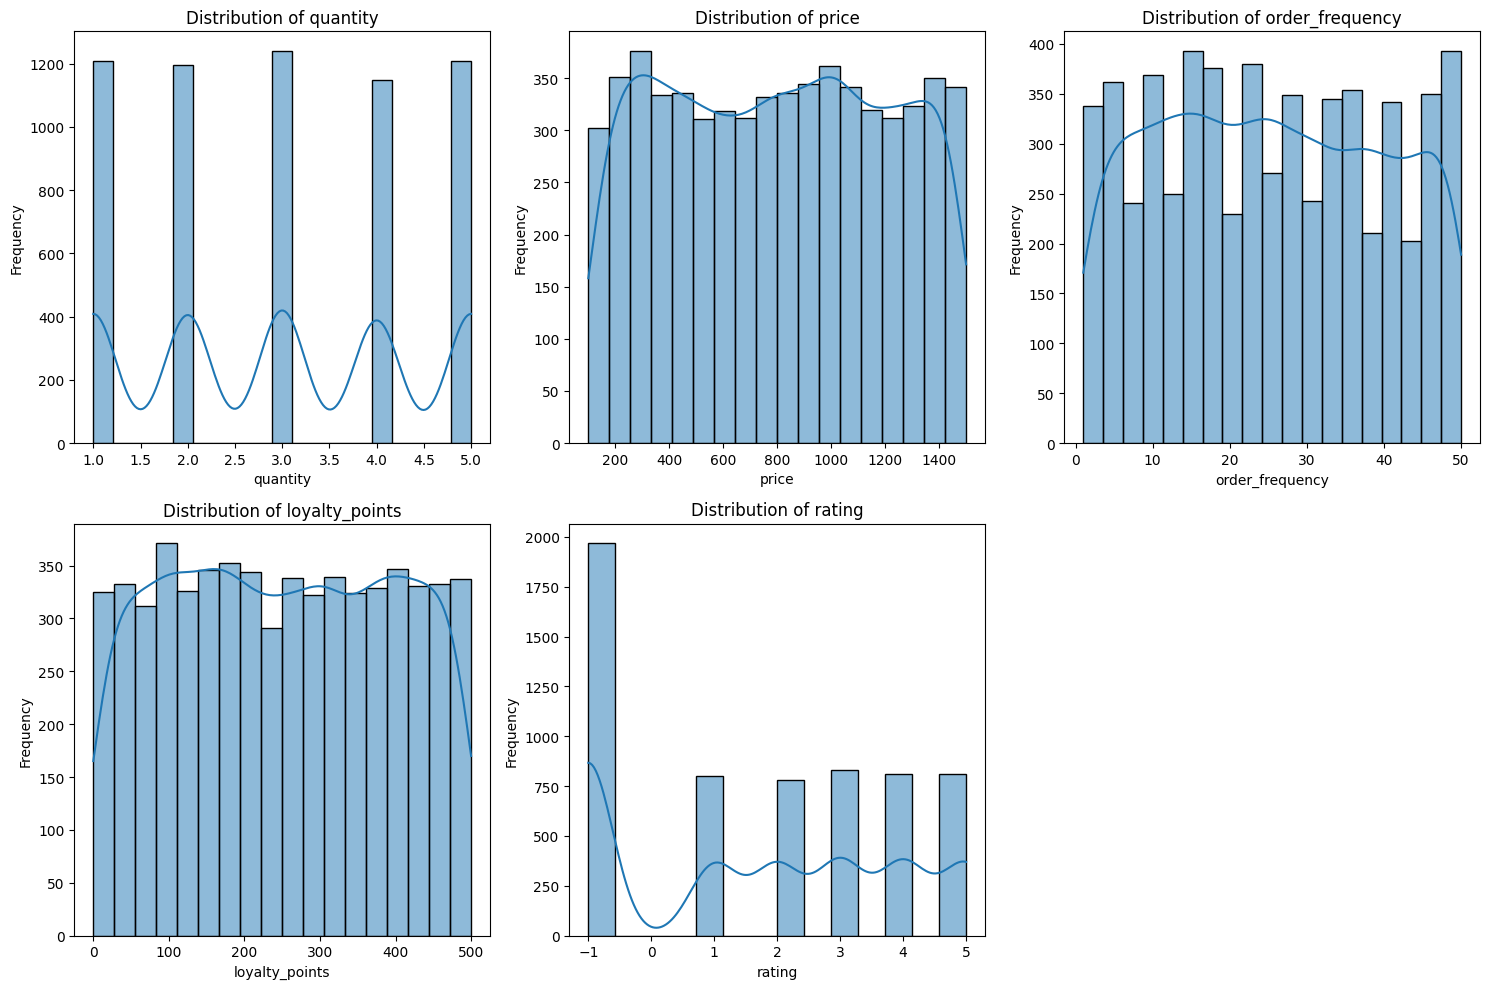

In [139]:
# Distribution Analysis with Visualisation
numerical_cols = ['quantity','price','order_frequency','loyalty_points','rating']
plt.figure(figsize=(15,10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2,3,i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('distribution_analysis.png')
plt.show()

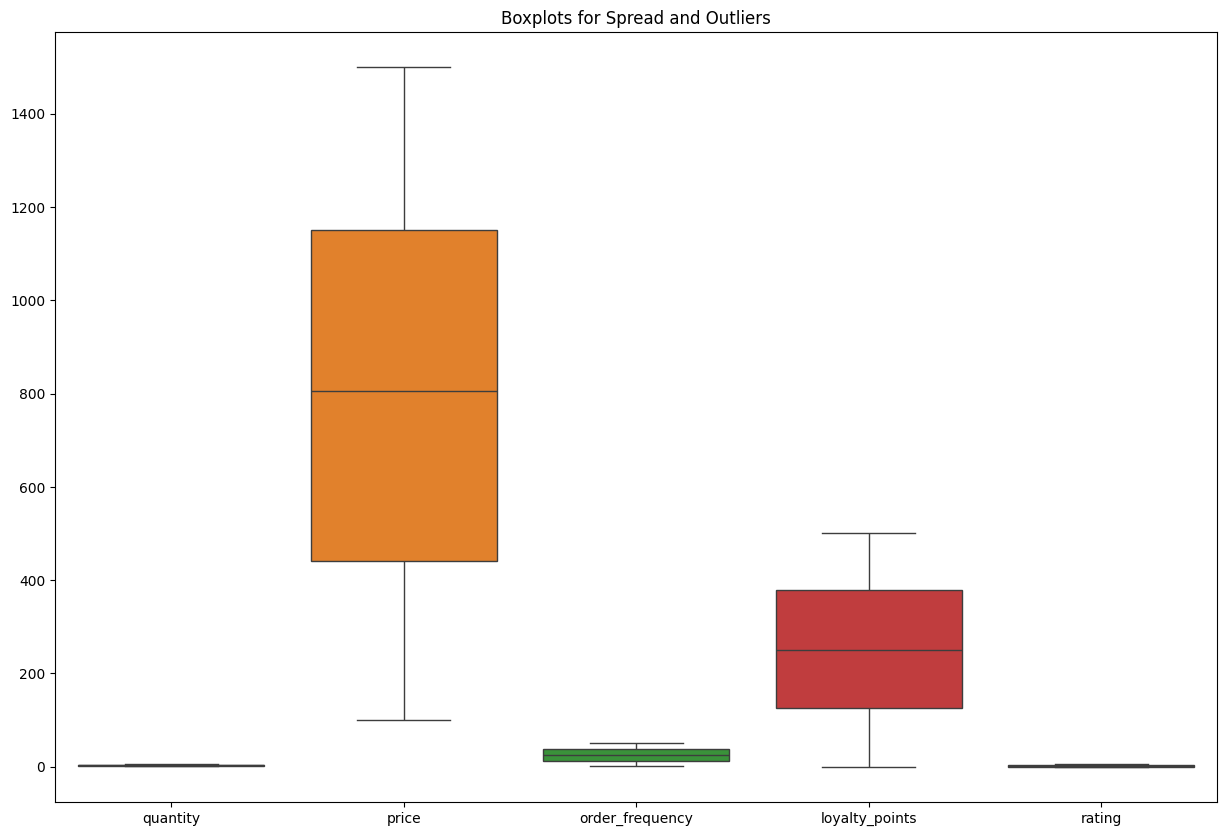

In [140]:
# Boxplots for spread and outliers
plt.figure(figsize=(15,10))
sns.boxplot(data=df[numerical_cols])
plt.title('Boxplots for Spread and Outliers')
plt.savefig('boxplots.png')
plt.show()

In [141]:
# Summary of Numerical Columns
print("\nNumerical Distributions Summary:\n", df[numerical_cols].describe())


Numerical Distributions Summary:
           quantity        price  order_frequency  loyalty_points       rating
count  6000.000000  6000.000000      6000.000000     6000.000000  6000.000000
mean      2.991667   800.524880        25.304667      250.173667     1.696167
std       1.414778   404.855029        14.358930      144.608478     2.210807
min       1.000000   100.300000         1.000000        0.000000    -1.000000
25%       2.000000   441.997500        13.000000      125.000000    -1.000000
50%       3.000000   806.460000        25.000000      249.500000     2.000000
75%       4.000000  1149.737500        37.000000      378.000000     4.000000
max       5.000000  1499.950000        50.000000      500.000000     5.000000


In [142]:
# Numerical Columns Skewnwss and Kurtosis Check
for col in numerical_cols:
    print(f"\n{col} Skewness: {skew(df[col].dropna())}")
    print(f"{col} Kurtosis: {kurtosis(df[col].dropna())}")


quantity Skewness: 0.014728803298780494
quantity Kurtosis: -1.2936849166040143

price Skewness: 0.0042878293881450855
price Kurtosis: -1.2113717927708592

order_frequency Skewness: 0.05068177821782105
order_frequency Kurtosis: -1.1752450024380743

loyalty_points Skewness: 0.008961291914319316
loyalty_points Kurtosis: -1.2078043261722444

rating Skewness: 0.03310015873057501
rating Kurtosis: -1.423183842273921


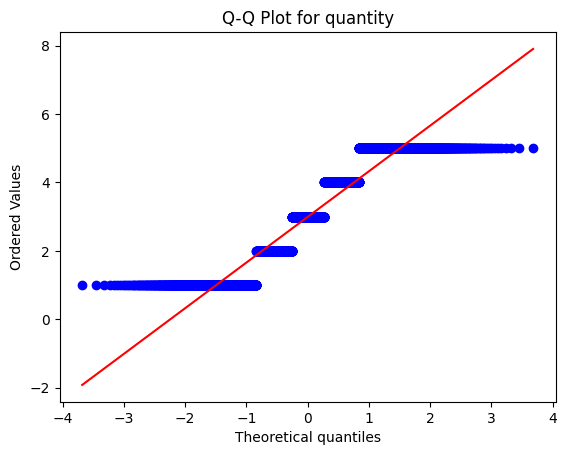

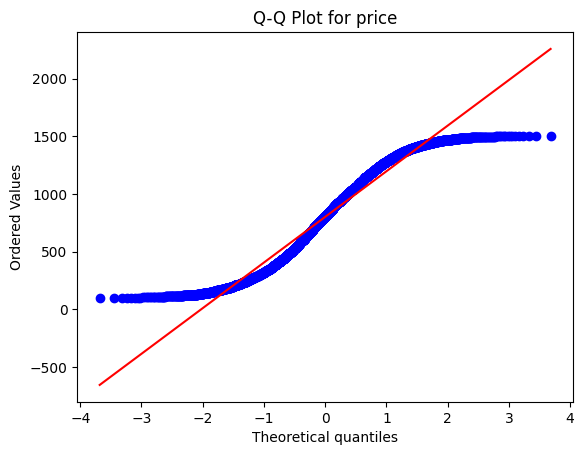

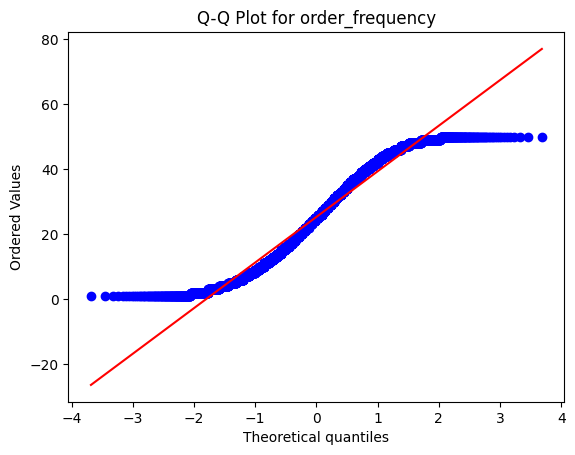

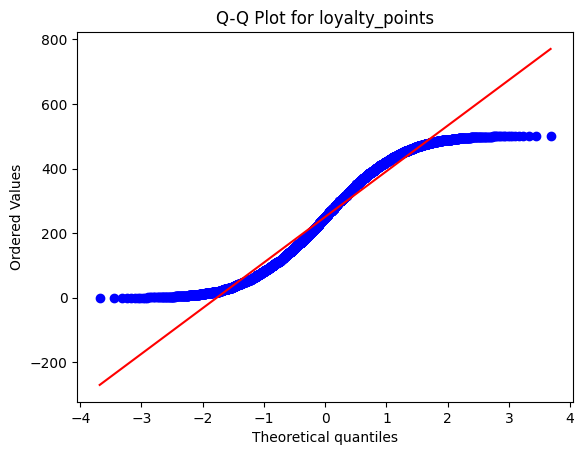

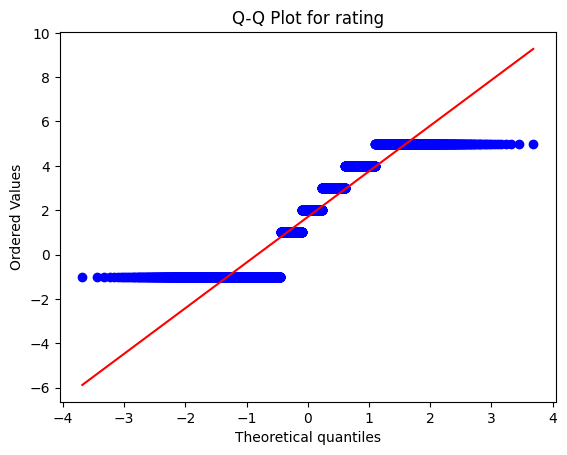

In [143]:
# QQ Plot for Numerical Columns
for col in numerical_cols:
    stats.probplot(df[col].dropna(), dist="norm", plot=plt)
    plt.title(f'Q-Q Plot for {col}')
    plt.show()

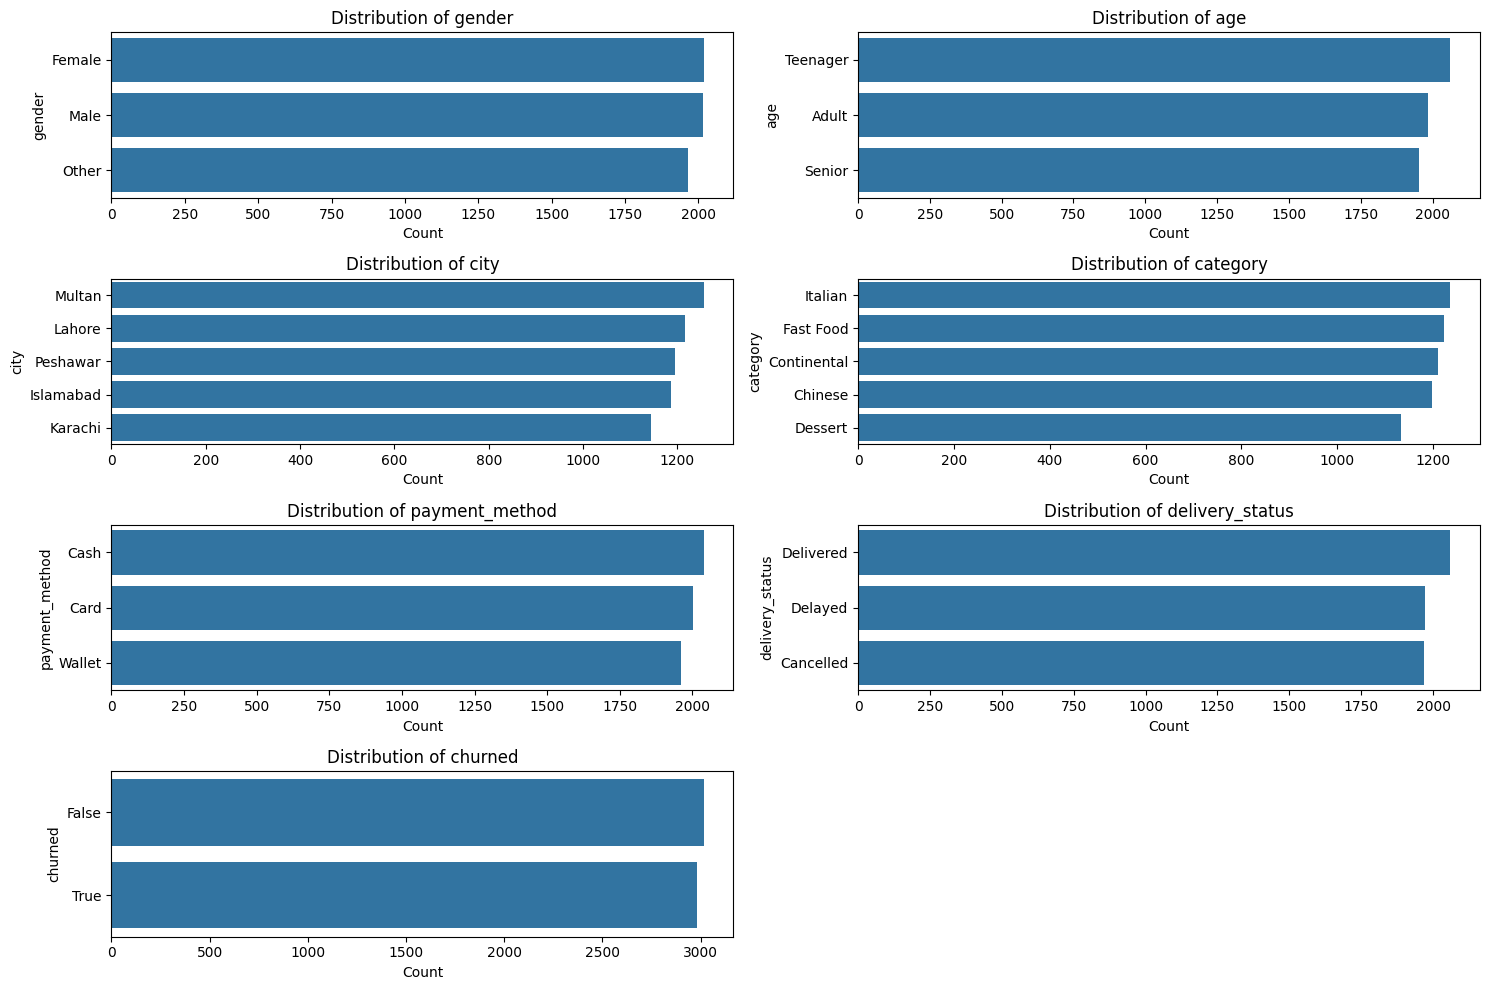

In [144]:
# Visualisatipn of Categorical Columns
categorical_cols = ['gender','age','city','category','payment_method','delivery_status','churned']
plt.figure(figsize=(15,10))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(4,2,i)
    sns.countplot(y=df[col],order=df[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xlabel('Count')
    plt.ylabel(col)
plt.tight_layout()
plt.savefig('categorical_distributions.png')
plt.show()

In [145]:
# Value Count of Categorical Column
for col in categorical_cols:
    print(f"\nValue Counts for {col}:\n", df[col].value_counts(normalize=True)*100)


Value Counts for gender:
 gender
Female    33.633333
Male      33.616667
Other     32.750000
Name: proportion, dtype: float64

Value Counts for age:
 age
Teenager    34.366667
Adult       33.066667
Senior      32.566667
Name: proportion, dtype: float64

Value Counts for city:
 city
Multan       20.933333
Lahore       20.283333
Peshawar     19.916667
Islamabad    19.783333
Karachi      19.083333
Name: proportion, dtype: float64

Value Counts for category:
 category
Italian        20.600000
Fast Food      20.366667
Continental    20.183333
Chinese        19.966667
Dessert        18.883333
Name: proportion, dtype: float64

Value Counts for payment_method:
 payment_method
Cash      33.983333
Card      33.366667
Wallet    32.650000
Name: proportion, dtype: float64

Value Counts for delivery_status:
 delivery_status
Delivered    34.333333
Delayed      32.866667
Cancelled    32.800000
Name: proportion, dtype: float64

Value Counts for churned:
 churned
False    50.266667
True     49.733333
N

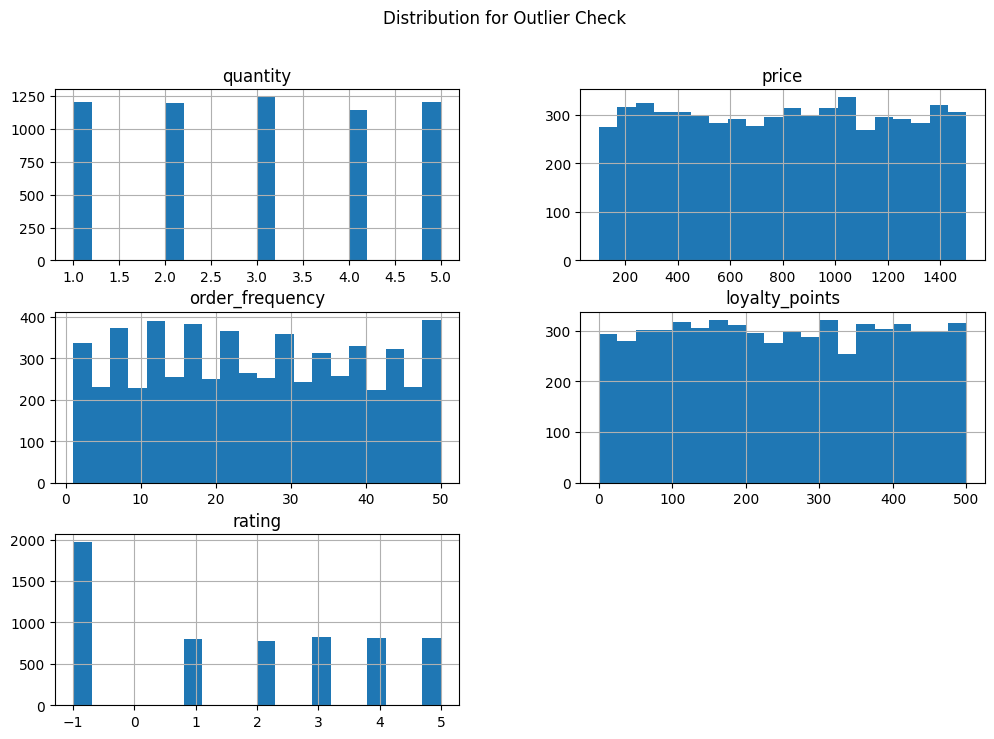

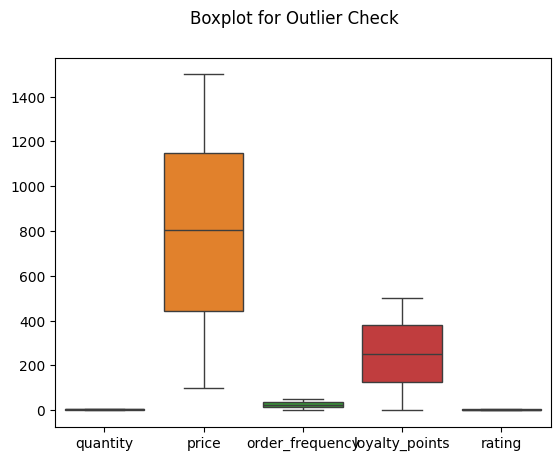

In [146]:
# Checking for the outliers visually
numerical_cols = ['quantity','price','order_frequency','loyalty_points','rating']
df[numerical_cols].hist(bins=20,figsize=(12,8))
plt.suptitle('Distribution for Outlier Check')
plt.savefig('distribution.png')
plt.show()

sns.boxplot(data=df[numerical_cols])
plt.suptitle('Boxplot for Outlier Check')
plt.savefig('boxplot.png')
plt.show()

In [147]:
# Outlier Detection
outliers_summary = {}
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    outliers_summary[col] = len(outliers)
print("\nOutliers Count per Column:\n", outliers_summary)


Outliers Count per Column:
 {'quantity': 0, 'price': 0, 'order_frequency': 0, 'loyalty_points': 0, 'rating': 0}


In [148]:
# Z- Score Calculation
z_scores = stats.zscore(df[numerical_cols].dropna())
abs_z_scores = np.abs(z_scores)
outliers_z = (abs_z_scores > 3).any(axis=1).sum()
print("\nRows with Z-Score Outliers (>3 std dev):", outliers_z)


Rows with Z-Score Outliers (>3 std dev): 0



Correlation Matrix:
                  quantity     price  order_frequency  loyalty_points    rating
quantity         1.000000 -0.007424         0.011473        0.006136 -0.005286
price           -0.007424  1.000000         0.011608       -0.013781  0.004202
order_frequency  0.011473  0.011608         1.000000        0.006744 -0.012327
loyalty_points   0.006136 -0.013781         0.006744        1.000000  0.016527
rating          -0.005286  0.004202        -0.012327        0.016527  1.000000


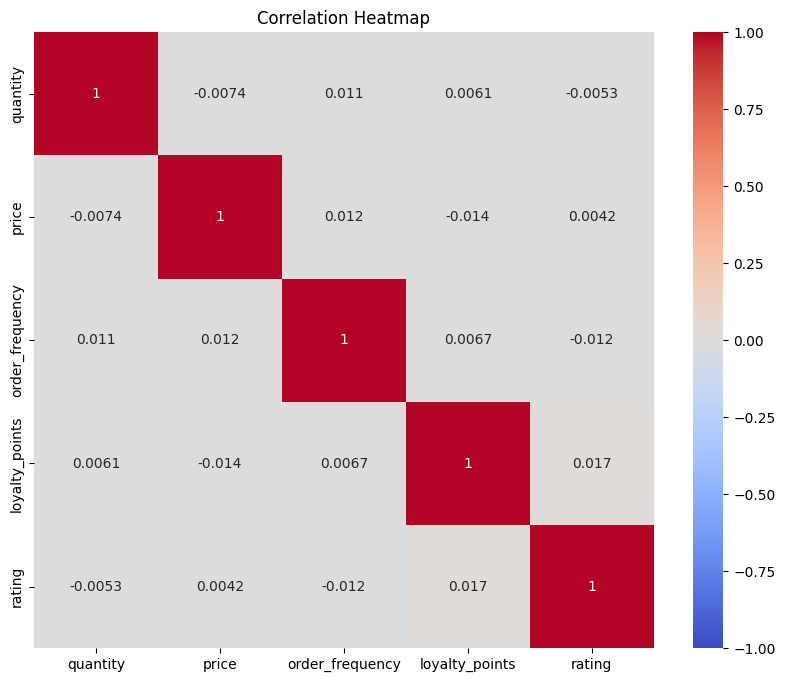

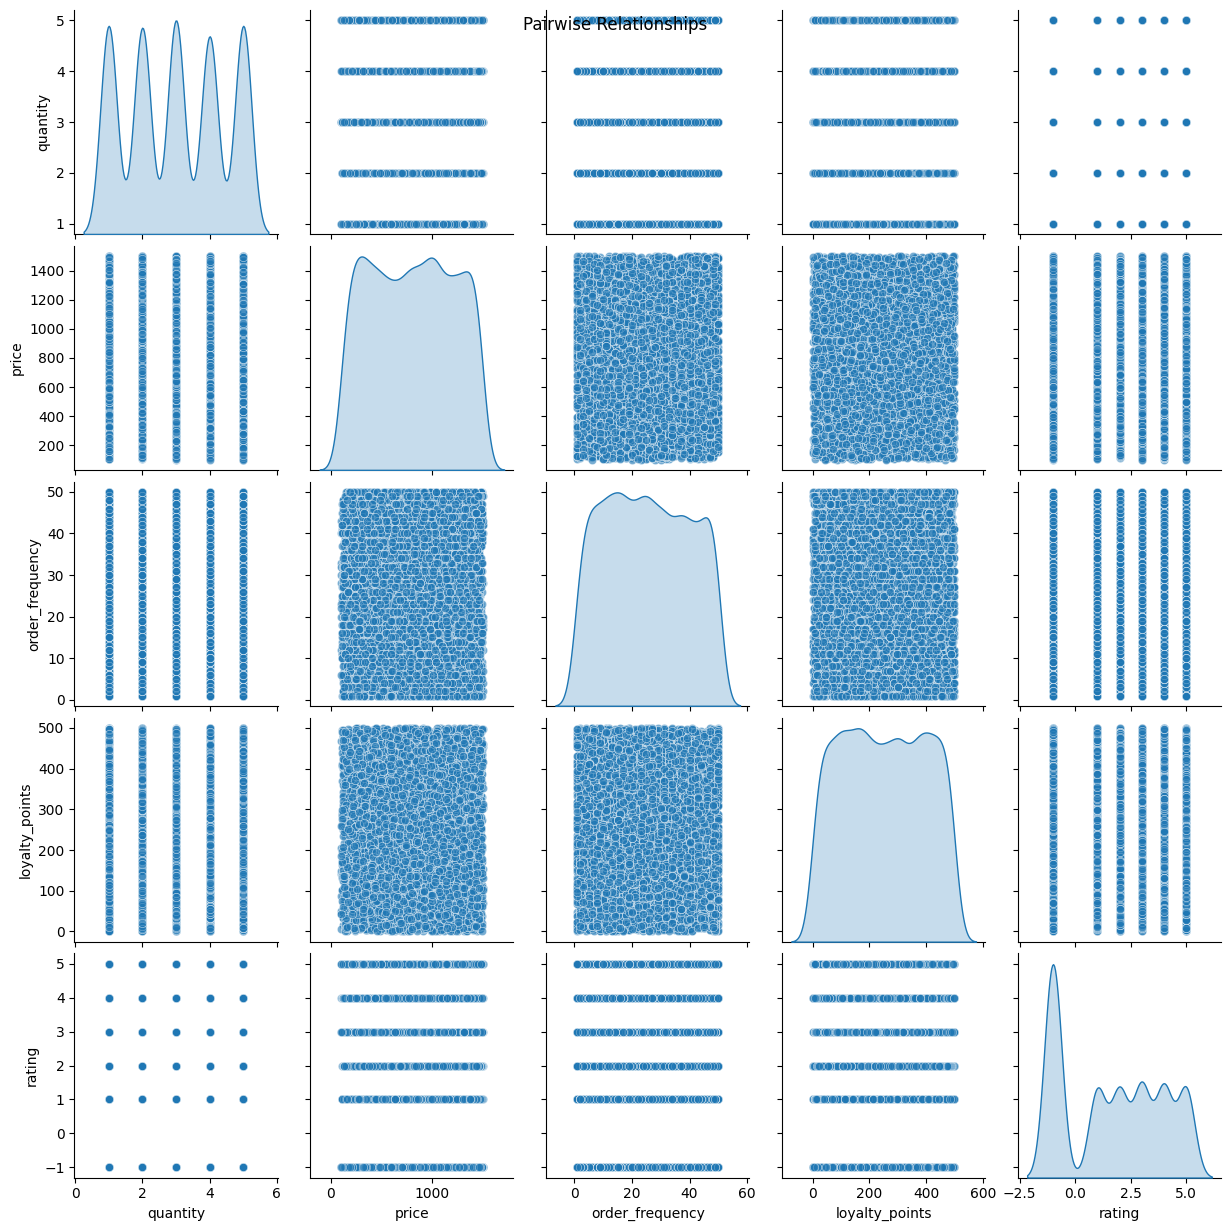

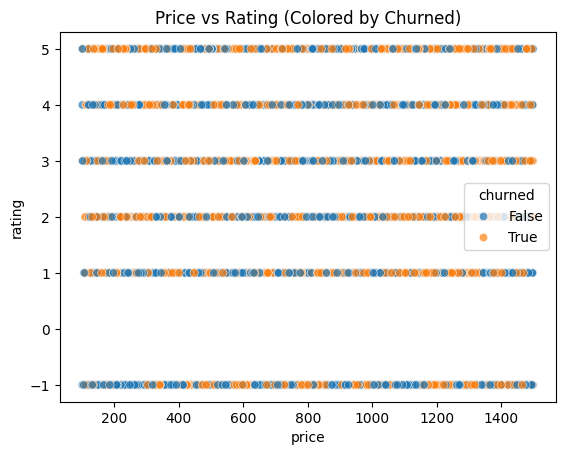

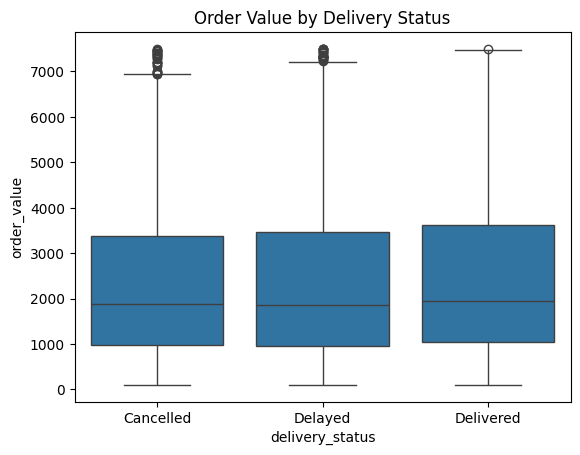

In [149]:
# Correlation and Relationship Checks
numerical_cols = ['quantity', 'price', 'order_frequency', 'loyalty_points', 'rating']
correlation_matrix = df[numerical_cols].corr(method='pearson')
print("\nCorrelation Matrix:\n", correlation_matrix)
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.savefig('correlation_heatmap.png')
plt.show()

sns.pairplot(df[numerical_cols], diag_kind='kde', plot_kws={'alpha':0.6})
plt.suptitle('Pairwise Relationships')
plt.savefig('pairwise_relationships.png')
plt.show()

# Specific Scatter Example (e.g., Price vs Rating)
sns.scatterplot(data=df, x='price', y='rating', hue='churned', alpha=0.7)
plt.title('Price vs Rating (Colored by Churned)')
plt.savefig('price_vs_rating.png')
plt.show()

# Boxplot for Numerical vs Categorical (e.g., Order Value by Delivery Status)
df['order_value'] = df['quantity'] * df['price']  # If not added yet
sns.boxplot(data=df, x='delivery_status', y='order_value')
plt.title('Order Value by Delivery Status')
plt.savefig('order_value_by_delivery.png')
plt.show()

In [150]:
# Derived Metrics for Quick Insights

# 1. Total Sales (Overall Revenue: Sum of quantity * price)
total_sales = (df['quantity'] * df['price']).sum()
print(f"\nTotal Sales (Revenue): ${total_sales:,.2f}")

# 2. Average Order Value (AOV: Mean of quantity * price per order)
df['order_value'] = df['quantity'] * df['price']
avg_order_value = df['order_value'].mean()
print(f"Average Order Value: ${avg_order_value:,.2f}")

# 3. Total Orders (Unique order_id count, if order_id kept; else row count assuming one per row)
total_orders = len(df)
print(f"Total Orders: {total_orders}")

# 4. Churn Rate ( % churned)
churn_rate = df['churned'].mean() * 100
print(f"Churn Rate: {churn_rate:.2f}%")

# 5. Retention Rate (Simple: 100 - churn_rate; or more advanced below)
retention_rate = 100 - churn_rate
print(f"Retention Rate: {retention_rate:.2f}%")

# 6. Average Rating (Excluding -1 for N/A)
avg_rating = df[df['rating'] != -1]['rating'].mean()
print(f"Average Rating: {avg_rating:.2f}")

# 7. Average Order Frequency and Loyalty Points
avg_order_freq = df['order_frequency'].mean()
avg_loyalty_points = df['loyalty_points'].mean()
print(f"Average Order Frequency: {avg_order_freq:.2f}")
print(f"Average Loyalty Points: {avg_loyalty_points:.2f}")

# 8. Delivery Success Rate (% 'delivered')
delivery_success = (df['delivery_status'] == 'delivered').mean() * 100
print(f"Delivery Success Rate: {delivery_success:.2f}%")

# Optional: Quick Viz for Insights (Bar for Top Categories by Sales)
top_categories = df.groupby('category')['order_value'].sum().sort_values(ascending=False).head(5)
fig = px.bar(top_categories.reset_index(), x='category', y='order_value', title='Top 5 Categories by Sales')
fig.show()


Total Sales (Revenue): $14,343,912.08
Average Order Value: $2,390.65
Total Orders: 6000
Churn Rate: 49.73%
Retention Rate: 50.27%
Average Rating: 3.01
Average Order Frequency: 25.30
Average Loyalty Points: 250.17
Delivery Success Rate: 0.00%


In [151]:
# Checking the column names
df.columns.to_list()

['customer_id',
 'gender',
 'age',
 'city',
 'signup_date',
 'order_date',
 'restaurant_name',
 'category',
 'quantity',
 'price',
 'payment_method',
 'order_frequency',
 'last_order_date',
 'loyalty_points',
 'churned',
 'rating',
 'delivery_status',
 'order_value']

In [152]:
# Check if any customer_id + order_date combo has multiple rows (potential multi-line orders)
potential_multi = df.groupby(['customer_id', 'order_date']).size()
multi_orders = potential_multi[potential_multi > 1].sum()
print(f"Multi-Line Orders: {multi_orders} rows")
if multi_orders > 0:
    total_orders = df.groupby(['customer_id', 'order_date']).ngroups  # Unique order groups if multi-lines
else:
    total_orders = len(df)
print(f"Total Orders: {total_orders}")

Multi-Line Orders: 0 rows
Total Orders: 6000


## **RFM Score**

In [153]:
# RFM Score Calculation
customer_rfm = df.groupby('customer_id').agg({
    'city' : 'first',
    'last_order_date' : 'max',
    'order_value' : 'sum',
    'order_frequency' : 'first'
})

current_date = pd.to_datetime('2025-12-28')
customer_rfm['recency'] = (current_date - customer_rfm['last_order_date']).dt.days

customer_rfm['r_score'] = pd.qcut(customer_rfm['recency'],5, labels=[5,4,3,2,1],duplicates='drop')
customer_rfm['f_score'] = pd.qcut(customer_rfm['order_frequency'],5, labels=[1,2,3,4,5],duplicates='drop')
customer_rfm['m_score'] = pd.qcut(customer_rfm['order_value'],5, labels=[1,2,3,4,5],duplicates='drop')

customer_rfm['rfm_score'] = customer_rfm['r_score'].astype(int) + customer_rfm['f_score'].astype(int) + customer_rfm['m_score'].astype(int)

features = ['r_score','f_score','m_score']
x = customer_rfm[features].astype(float)



In [154]:
# Saving the individual city files
df_with_rfm = df.merge(customer_rfm[['r_score','f_score','m_score', 'rfm_score']], on = 'customer_id', how = 'left')
columns = [
    'customer_id','gender','age','city','signup_date','order_date','restaurant_name','category','quantity','price','payment_method','order_frequency','last_order_date','loyalty_points','churned','rating','delivery_status','order_value', 'r_score','f_score','m_score','rfm_score']
cities = df_with_rfm['city'].unique()
for city in cities:
    city_df = df_with_rfm[df_with_rfm['city'] == city][columns]
    filename = f'{city}_data.csv'
    city_df.to_csv(filename , index=False)
    print(f"Saved {filename} with {len(city_df)} rows")

Saved Peshawar_data.csv with 1195 rows
Saved Multan_data.csv with 1256 rows
Saved Lahore_data.csv with 1217 rows
Saved Karachi_data.csv with 1145 rows
Saved Islamabad_data.csv with 1187 rows


# **Analysis in SQL**

## **SQL Connection Building**

In [155]:
!pip install duckdb
import duckdb
import pandas as pd

In [156]:
con = duckdb.connect()
con.register('foodpanda', df_with_rfm)

In [157]:
cities = ['Islamabad','Karachi','Lahore','Multan','Peshawar']
for city in cities:
    city_df = pd.read_csv(f'{city}_data.csv')
    con.register(f'{city}_table', city_df)
    print(f"Loaded {city} table.")


Loaded Islamabad table.
Loaded Karachi table.
Loaded Lahore table.
Loaded Multan table.
Loaded Peshawar table.


## **Churn Rate Analysis**

In [158]:
# Overall Churn Rate
query = """
SELECT CAST(ROUND(AVG(CAST(churned AS INT)) * 100, 2) AS STRING) || '%' AS overall_churn_rate_percent
FROM foodpanda;
"""
overall_churn_rate_str = con.execute(query).fetchone()[0]
print(overall_churn_rate_str)

# Convert the string result to a pandas DataFrame and then save
overall_churn_df = pd.DataFrame({'overall_churn_rate_percent': [overall_churn_rate_str]})
overall_churn_df.to_csv('overall_churn.csv', index=False)
print(f"Saved overall_churn.csv")

49.73%
Saved overall_churn.csv


In [159]:
# Churn Analysis by RFM for Each City
for city in cities:
    print(f"\nCHURN ANALYSIS BY RFM ({city.upper()})")
    query = f"""
    SELECT rfm_score,
           ROUND(AVG(CAST(churned AS INT)) * 100, 2) AS churn_rate_percent,
           COUNT(*) AS customer_count
    FROM {city}_table
    GROUP BY rfm_score
    ORDER BY churn_rate_percent DESC;
    """
    churn_by_rfm = con.execute(query).df()
    print(churn_by_rfm)
    churn_by_rfm.to_csv(f'{city}_churn_by_rfm.csv', index=False)
    print(f"Saved {city}_churn_by_rfm.csv")


CHURN ANALYSIS BY RFM (ISLAMABAD)
    rfm_score  churn_rate_percent  customer_count
0           4               60.00              35
1          10               54.76             168
2          12               51.06              94
3           7               51.05             143
4           8               50.00             154
5           3               50.00              14
6          15               50.00               6
7           9               48.72             195
8          13               47.27              55
9           6               46.51              86
10         11               45.77             142
11          5               41.79              67
12         14               35.71              28
Saved Islamabad_churn_by_rfm.csv

CHURN ANALYSIS BY RFM (KARACHI)
    rfm_score  churn_rate_percent  customer_count
0          14               57.89              19
1           4               51.85              27
2          10               50.60             168

In [160]:
# Churn Analysis by City
query = """
SELECT city,
       ROUND(AVG(CAST(churned AS INT)) * 100, 2) AS churn_rate_percent,
       COUNT(*) AS customer_count
FROM foodpanda
GROUP BY city
ORDER BY churn_rate_percent DESC;
"""
churn_by_city = con.execute(query).df()
print(churn_by_city)
churn_by_city.to_csv('churn_by_city.csv', index=False)
print("Saved churn_by_city.csv")

        city  churn_rate_percent  customer_count
0     Lahore               51.85            1217
1     Multan               51.59            1256
2  Islamabad               49.28            1187
3   Peshawar               47.87            1195
4    Karachi               47.86            1145
Saved churn_by_city.csv


In [161]:
# Churn Analysis by Demographics (Age/Gender) for Each City
for city in cities:
    print(f"\nCHURN ANALYSIS BY DEMOGRAPHICS (AGE/GENDER) ({city.upper()})")
    query = f"""
    SELECT age, gender,
           ROUND(AVG(CAST(churned AS INT)) * 100, 2) AS churn_rate_percent,
           COUNT(*) AS customer_count
    FROM {city}_table
    GROUP BY age, gender
    ORDER BY churn_rate_percent DESC;
    """
    churn_by_demo = con.execute(query).df()
    print(churn_by_demo)
    churn_by_demo.to_csv(f'{city}_churn_by_demo.csv', index=False)
    print(f"Saved {city}_churn_by_demo.csv")


CHURN ANALYSIS BY DEMOGRAPHICS (AGE/GENDER) (ISLAMABAD)
        age  gender  churn_rate_percent  customer_count
0     Adult    Male               52.55             137
1    Senior  Female               51.88             133
2  Teenager  Female               51.45             138
3  Teenager    Male               49.64             139
4     Adult   Other               49.28             138
5    Senior   Other               48.91              92
6     Adult  Female               47.01             134
7  Teenager   Other               46.67             150
8    Senior    Male               46.03             126
Saved Islamabad_churn_by_demo.csv

CHURN ANALYSIS BY DEMOGRAPHICS (AGE/GENDER) (KARACHI)
        age  gender  churn_rate_percent  customer_count
0  Teenager   Other               55.93             118
1    Senior   Other               54.17             120
2    Senior  Female               50.41             121
3     Adult   Other               49.66             147
4    Senior   

In [162]:
# Churn Analysis by Features (Rating/Delivery) for Each City
for city in cities:
    print(f"\nCHURN ANALYSIS BY FEATURES (RATING/DELIVERY) ({city.upper()})")
    query = f"""
    SELECT
      CASE
        WHEN rating < 3 THEN 'Low (<3)'
        WHEN rating BETWEEN 3 AND 4 THEN 'Medium (3-4)'
        ELSE 'High (>4)'
      END AS rating_bucket,
      delivery_status,
      ROUND(AVG(CAST(churned AS INT)) * 100, 2) AS churn_rate_percent,
      COUNT(*) AS customer_count
    FROM {city}_table
    GROUP BY rating_bucket, delivery_status
    ORDER BY churn_rate_percent DESC;
    """
    churn_by_features = con.execute(query).df()
    print(churn_by_features)
    churn_by_features.to_csv(f'{city}_churn_by_features.csv', index=False)
    print(f"Saved {city}_churn_by_features.csv")


CHURN ANALYSIS BY FEATURES (RATING/DELIVERY) (ISLAMABAD)
  rating_bucket delivery_status  churn_rate_percent  customer_count
0     High (>4)         Delayed               57.50              80
1      Low (<3)       Delivered               56.13             155
2      Low (<3)         Delayed               53.50             157
3     High (>4)       Delivered               48.19              83
4  Medium (3-4)       Delivered               47.93             169
5  Medium (3-4)         Delayed               47.40             154
6      Low (<3)       Cancelled               44.73             389
Saved Islamabad_churn_by_features.csv

CHURN ANALYSIS BY FEATURES (RATING/DELIVERY) (KARACHI)
  rating_bucket delivery_status  churn_rate_percent  customer_count
0      Low (<3)       Cancelled               49.30             357
1      Low (<3)         Delayed               48.98             147
2      Low (<3)       Delivered               48.43             159
3  Medium (3-4)         Delayed 

## **Retention Rate Analysis**

In [163]:
# Overall Retention Rate
query = """
SELECT CAST(ROUND(AVG(CASE WHEN order_frequency > 1 THEN 1 ELSE 0 END) * 100, 2) AS STRING) || '%' AS overall_retention_rate_percent
FROM foodpanda;
"""
overall_retention_rate_str = con.execute(query).fetchone()[0]
print(overall_retention_rate_str)
# Convert the string result to a pandas DataFrame and then save
overall_retention_df = pd.DataFrame({'overall_retention_rate_percent': [overall_retention_rate_str]})
overall_retention_df.to_csv('overall_retention.csv', index=False)
print(f"Saved overall_retention.csv")

98.02%
Saved overall_retention.csv


In [164]:
# Retention Rate Analysis by RFM
for city in cities:
    print(f"\nRETENTION BY RFM ({city.upper()})")
    query = f"""
    SELECT rfm_score,
      ROUND(SUM(CASE WHEN order_frequency > 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(DISTINCT customer_id), 2) AS repeat_rate_percent,
      COUNT(DISTINCT customer_id) AS customer_count
    FROM {city}_table
    GROUP BY rfm_score
    ORDER BY repeat_rate_percent DESC;
    """
    retention_by_rfm = con.execute(query).df()
    print(retention_by_rfm)
    retention_by_rfm.to_csv(f'{city}_retention_by_rfm.csv', index=False)
    print(f"Saved {city}_retention_by_rfm.csv")


RETENTION BY RFM (ISLAMABAD)
    rfm_score  repeat_rate_percent  customer_count
0          13               100.00              55
1          12               100.00              94
2          14               100.00              28
3          15               100.00               6
4          10                99.40             168
5           9                98.97             195
6           7                97.20             143
7          11                97.18             142
8           6                96.51              86
9           8                96.10             154
10          4                94.29              35
11          5                94.03              67
12          3                85.71              14
Saved Islamabad_retention_by_rfm.csv

RETENTION BY RFM (KARACHI)
    rfm_score  repeat_rate_percent  customer_count
0          14               100.00              19
1          15               100.00               4
2          12               100.00    

In [165]:
# Retention Analysis by Demographics (Age/Gender) for Each City
for city in cities:
    print(f"\nRETENTION ANALYSIS BY DEMOGRAPHICS (AGE/GENDER) ({city.upper()})")
    query = f"""
    SELECT age, gender,
           ROUND(SUM(CASE WHEN order_frequency > 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS retention_rate_percent,
           COUNT(*) AS customer_count
    FROM {city}_table
    GROUP BY age, gender
    ORDER BY retention_rate_percent DESC;
    """
    retention_by_demo = con.execute(query).df()
    print(retention_by_demo)
    retention_by_demo.to_csv(f'{city}_retention_by_demo.csv', index=False)
    print(f"Saved {city}_retention_by_demo.csv")


RETENTION ANALYSIS BY DEMOGRAPHICS (AGE/GENDER) (ISLAMABAD)
        age  gender  retention_rate_percent  customer_count
0     Adult   Other                   99.28             138
1    Senior    Male                   99.21             126
2    Senior   Other                   98.91              92
3     Adult    Male                   98.54             137
4  Teenager    Male                   97.84             139
5  Teenager  Female                   97.83             138
6    Senior  Female                   96.99             133
7  Teenager   Other                   96.67             150
8     Adult  Female                   94.03             134
Saved Islamabad_retention_by_demo.csv

RETENTION ANALYSIS BY DEMOGRAPHICS (AGE/GENDER) (KARACHI)
        age  gender  retention_rate_percent  customer_count
0     Adult   Other                  100.00             147
1  Teenager    Male                   99.22             128
2     Adult    Male                   99.19             123
3 

In [166]:
# Retention Analysis by Features (Rating/Delivery) for Each City
for city in cities:
    print(f"\nRETENTION ANALYSIS BY FEATURES (RATING/DELIVERY) ({city.upper()})")
    query = f"""
    SELECT
      CASE
        WHEN rating < 3 THEN 'Low (<3)'
        WHEN rating BETWEEN 3 AND 4 THEN 'Medium (3-4)'
        ELSE 'High (>4)'
      END AS rating_bucket,
      delivery_status,
      ROUND(SUM(CASE WHEN order_frequency > 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS retention_rate_percent,
      COUNT(*) AS customer_count
    FROM {city}_table
    GROUP BY rating_bucket, delivery_status
    ORDER BY retention_rate_percent DESC;
    """
    retention_by_features = con.execute(query).df()
    print(retention_by_features)
    retention_by_features.to_csv(f'{city}_retention_by_features.csv', index=False)
    print(f"Saved {city}_retention_by_features.csv")


RETENTION ANALYSIS BY FEATURES (RATING/DELIVERY) (ISLAMABAD)
  rating_bucket delivery_status  retention_rate_percent  customer_count
0     High (>4)         Delayed                  100.00              80
1      Low (<3)       Cancelled                   98.46             389
2      Low (<3)       Delivered                   98.06             155
3  Medium (3-4)       Delivered                   97.63             169
4     High (>4)       Delivered                   97.59              83
5      Low (<3)         Delayed                   96.18             157
6  Medium (3-4)         Delayed                   95.45             154
Saved Islamabad_retention_by_features.csv

RETENTION ANALYSIS BY FEATURES (RATING/DELIVERY) (KARACHI)
  rating_bucket delivery_status  retention_rate_percent  customer_count
0  Medium (3-4)       Delivered                  100.00             183
1      Low (<3)       Cancelled                   98.88             357
2      Low (<3)         Delayed             

In [167]:
# Retention Analysis by City
query = """
SELECT city,
       ROUND(AVG(CASE WHEN order_frequency > 1 THEN 1 ELSE 0 END) * 100, 2) AS retention_rate_percent,
       COUNT(*) AS customer_count
FROM foodpanda
GROUP BY city
ORDER BY retention_rate_percent DESC;
"""
retention_by_city = con.execute(query).df()
print(retention_by_city)
retention_by_city.to_csv('retention_by_city.csv', index=False)
print("Saved retention_by_city.csv")

        city  retention_rate_percent  customer_count
0   Peshawar                   98.49            1195
1    Karachi                   98.17            1145
2     Multan                   97.93            1256
3     Lahore                   97.86            1217
4  Islamabad                   97.64            1187
Saved retention_by_city.csv


## **Performance Analysis**

In [168]:
# Performance Analysis
for city in cities:
    print(f"\nPerformance Analysis for {city} :")
    print('-----------------------')

    performance_query = f"""
      SELECT
        SUM(order_value) AS total_revenue,
        AVG(order_value) AS avg_order_value,
        AVG(rating) AS avg_rating,
        ROUND(SUM(CASE WHEN delivery_status LIKE 'Delivered' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS delivery_success_rate_on_time,
        ROUND(SUM(CASE WHEN delivery_status LIKE 'Delayed' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS delivery_success_rate_delayed,
        ROUND(SUM(CASE WHEN delivery_status LIKE 'Cancelled' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS delivery_success_rate_cancelled
      FROM {city}_table;
    """
    performance_df = con.execute(performance_query).df()
    print(performance_df)
    performance_df.to_csv(f'{city}_performance.csv', index=False)
    print(f"Saved {city}_performance_overall.csv")

    print('-----------------------')

    print('Top Categories by Revenue:')
    print('-----------------------')


    # Top Restaurants
    restaurant_perf_query = f"""
      SELECT restaurant_name, SUM(order_value) AS total_revenue, AVG(rating) AS avg_rating
      FROM {city}_table
      GROUP BY restaurant_name
      ORDER BY total_revenue DESC LIMIT 5;
    """
    restaurant_df = con.execute(restaurant_perf_query).df()
    print(restaurant_df)
    restaurant_df.to_csv(f'{city}_performance_by_restaurant.csv', index=False)
    print(f'Saved {city}_performance_by_restaurant.csv')




Performance Analysis for Islamabad :
-----------------------
   total_revenue  avg_order_value  avg_rating  delivery_success_rate_on_time  \
0     2835310.27      2388.635442    1.706824                          34.29   

   delivery_success_rate_delayed  delivery_success_rate_cancelled  
0                          32.94                            32.77  
Saved Islamabad_performance_overall.csv
-----------------------
Top Categories by Revenue:
-----------------------
  restaurant_name  total_revenue  avg_rating
0             KFC      679551.15    1.804428
1     Burger King      558912.50    1.470588
2       Pizza Hut      552153.71    1.787037
3          Subway      544610.01    1.727273
4      McDonald's      500082.90    1.740909
Saved Islamabad_performance_by_restaurant.csv

Performance Analysis for Karachi :
-----------------------
   total_revenue  avg_order_value  avg_rating  delivery_success_rate_on_time  \
0     2633229.28      2299.763563    1.758952                         

# **Combining the DFs**


In [169]:
# List of cities
cities = ['Islamabad', 'Karachi', 'Lahore', 'Multan', 'Peshawar']

# Combine churn_by_rfm files
combined_df = pd.DataFrame()
for city in cities:
    file_path = f'{city}_churn_by_rfm.csv'
    city_df = pd.read_csv(file_path)
    city_df['city'] = city  # Add 'city' column
    combined_df = pd.concat([combined_df, city_df], ignore_index=True)

# Save combined file
combined_df.to_csv('combined_churn_by_rfm.csv', index=False)
print(f"Saved combined_churn_by_rfm.csv with {len(combined_df)} rows.")

Saved combined_churn_by_rfm.csv with 65 rows.


In [170]:
# List of cities
cities = ['Islamabad', 'Karachi', 'Lahore', 'Multan', 'Peshawar']

# Combine churn_by_demo files
combined_df_demo = pd.DataFrame()
for city in cities:
    file_path = f'{city}_churn_by_demo.csv'
    city_df = pd.read_csv(file_path)
    city_df['city'] = city  # Add 'city' column
    combined_df_demo = pd.concat([combined_df_demo, city_df], ignore_index=True)

# Save combined file
combined_df_demo.to_csv('combined_churn_by_demo.csv', index=False)
print(f"Saved combined_churn_by_demo.csv with {len(combined_df_demo)} rows.")

Saved combined_churn_by_demo.csv with 45 rows.


In [171]:
# List of cities
cities = ['Islamabad', 'Karachi', 'Lahore', 'Multan', 'Peshawar']

# Combine churn_by_demo files
combined_df_features = pd.DataFrame()
for city in cities:
    file_path = f'{city}_churn_by_features.csv'
    city_df = pd.read_csv(file_path)
    city_df['city'] = city  # Add 'city' column
    combined_df_features = pd.concat([combined_df_features, city_df], ignore_index=True)

# Save combined file
combined_df_features.to_csv('combined_churn_by_features.csv', index=False)
print(f"Saved combined_churn_by_features.csv with {len(combined_df_features)} rows.")

Saved combined_churn_by_features.csv with 35 rows.


In [172]:
# List of cities
cities = ['Islamabad', 'Karachi', 'Lahore', 'Multan', 'Peshawar']

# Combine churn_by_demo files
retention_df_rfm = pd.DataFrame()
for city in cities:
    file_path = f'{city}_retention_by_rfm.csv'
    city_df = pd.read_csv(file_path)
    city_df['city'] = city  # Add 'city' column
    retention_df_rfm = pd.concat([retention_df_rfm, city_df], ignore_index=True)

# Save combined file
retention_df_rfm.to_csv('combined_retention_by_rfm.csv', index=False)
print(f"Saved combined_retention_by_rfm.csv with {len(retention_df_rfm)} rows.")

Saved combined_retention_by_rfm.csv with 65 rows.


In [173]:
# List of cities
cities = ['Islamabad', 'Karachi', 'Lahore', 'Multan', 'Peshawar']

# Combine churn_by_demo files
retention_df_demo = pd.DataFrame()
for city in cities:
    file_path = f'{city}_retention_by_demo.csv'
    city_df = pd.read_csv(file_path)
    city_df['city'] = city  # Add 'city' column
    retention_df_demo = pd.concat([retention_df_demo, city_df], ignore_index=True)

# Save combined file
retention_df_demo.to_csv('combined_retention_by_demo.csv', index=False)
print(f"Saved combined_retention_by_demo.csv with {len(retention_df_demo)} rows.")

Saved combined_retention_by_demo.csv with 45 rows.


In [174]:
# List of cities
cities = ['Islamabad', 'Karachi', 'Lahore', 'Multan', 'Peshawar']

# Combine churn_by_demo files
retention_df_features = pd.DataFrame()
for city in cities:
    file_path = f'{city}_retention_by_features.csv'
    city_df = pd.read_csv(file_path)
    city_df['city'] = city  # Add 'city' column
    retention_df_features = pd.concat([retention_df_features, city_df], ignore_index=True)

# Save combined file
retention_df_features.to_csv('combined_retention_by_features.csv', index=False)
print(f"Saved combined_retention_by_features.csv with {len(retention_df_features)} rows.")

Saved combined_retention_by_features.csv with 35 rows.


In [175]:
# List of cities
cities = ['Islamabad', 'Karachi', 'Lahore', 'Multan', 'Peshawar']

# Combine churn_by_demo files
perf_overall_df = pd.DataFrame()
for city in cities:
    file_path = f'{city}_performance.csv'
    city_df = pd.read_csv(file_path)
    city_df['city'] = city  # Add 'city' column
    perf_overall_df = pd.concat([perf_overall_df, city_df], ignore_index=True)

# Save combined file
perf_overall_df.to_csv('combined_perf_overall.csv', index=False)
print(f"Saved combined_perf_overall.csv with {len(perf_overall_df)} rows.")

Saved combined_perf_overall.csv with 5 rows.


In [176]:
# List of cities
cities = ['Islamabad', 'Karachi', 'Lahore', 'Multan', 'Peshawar']

# Combine churn_by_demo files
perf_rest_df = pd.DataFrame()
for city in cities:
    file_path = f'{city}_performance_by_restaurant.csv'
    city_df = pd.read_csv(file_path)
    city_df['city'] = city  # Add 'city' column
    perf_rest_df = pd.concat([perf_rest_df, city_df], ignore_index=True)

# Save combined file
perf_rest_df.to_csv('combined_perf_rest.csv', index=False)
print(f"Saved combined_perf_rest.csv with {len(perf_rest_df)} rows.")

Saved combined_perf_rest.csv with 25 rows.
